# Goal

There is a need to respond quickly to changes in today's world. This response may sometimes require understanding of a topic. Given any topic, there is a plethora of sources providing seas of data related to the it. Given todays world condition, a global concern is the treatment and handling of the COVID-19 pandemic. Given the rising amount of literature regarding the subject, it will be difficult for a scientist to keep up with today's literature.
> Is it possible to cluster these tens of thousands of articles to make it easier for a scientist to find relevant research articles?



In [1]:
from datetime import datetime
start_time = datetime.now()
import pandas as pd
import numpy as np
import os
import json
import glob
import matplotlib.pyplot as plt
from hdfs import InsecureClient

end_time = datetime.now()
print(f'Time for imports only: {end_time-start_time}')

Time for imports only: 0:00:02.586944


### Reading files into Spark RDDs with PySpark

In [2]:
from pyspark import SparkConf, SparkContext

conf = SparkConf().setAppName("SparkTFIDF")
sc = SparkContext(conf=conf)

hdfs_folder = 'hdfs://madison:31802/cord19dataset/metadata.csv'

def read_data(hdfs_folder):
    data = sc.parallelize([])
    data = sc.textFile(hdfs_folder)
    return data

meta = read_data(hdfs_folder)
sc.stop()

In [3]:
meta

hdfs://madison:31802/cord19dataset/metadata.csv MapPartitionsRDD[2] at textFile at NativeMethodAccessorImpl.java:0

## Reading all files from HDFS

In [4]:
client_hdfs = InsecureClient('http://madison:31802')

In [5]:
client_hdfs.content('/cord19dataset')

{'directoryCount': 17,
 'fileCount': 59317,
 'length': 7913288034,
 'quota': -1,
 'spaceConsumed': 23739864102,
 'spaceQuota': -1,
 'typeQuota': {}}

In [6]:
fnames = client_hdfs.list('/cord19dataset')
fnames

['COVID.DATA.LIC.AGMT.pdf',
 'biorxiv_medrxiv',
 'biorxiv_medrxiv.tar.gz',
 'comm_use_subset',
 'cord19_specter_embeddings_2020-04-10',
 'custom_license',
 'json_schema.txt',
 'metadata.csv',
 'metadata.readme',
 'noncomm_use_subset']

In [7]:
fnames = client_hdfs.list('/cord19dataset/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json')
fnames[0:50]

['0015023cc06b5362d332b3baf348d11567ca2fbb.json',
 '00340eea543336d54adda18236424de6a5e91c9d.json',
 '004f0f8bb66cf446678dc13cf2701feec4f36d76.json',
 '00911cf4f99a3d5ae5e5b787675646a743574496.json',
 '00d16927588fb04d4be0e6b269fc02f0d3c2aa7b.json',
 '00eb9220dc8cd351393b6b035323d350f103f8c6.json',
 '0139ea4ca580af99b602c6435368e7fdbefacb03.json',
 '013d9d1cba8a54d5d3718c229b812d7cf91b6c89.json',
 '018fb5e62fbbcae07d57d94d29ac630dcc4dccf9.json',
 '01d162d7fae6aaba8e6e60e563ef4c2fca7b0e18.json',
 '01e3b313e78a352593be2ff64927192af66619b5.json',
 '02201e4601ab0eb70b6c26480cf2bfeae2625193.json',
 '0255ea4b2f26a51a3bfa3bd8f3e1978c82c976d5.json',
 '029c1c588047f1d612a219ee15494d2d19ff7439.json',
 '0313c3faa16cd66d64f31ae37e40fb70695d69fb.json',
 '033ea7af3e6137df652de026f0751ac435327b75.json',
 '03813d8657ba43ea382788caec2d14257b26d8fd.json',
 '03ce432f27c7df6af22b92245a614db2ecb5de5f.json',
 '03ea3a614b56409d3f099c9ad764864293132540.json',
 '03ea9ad47ebe9a599205b99390c45490e6724024.json',


In [8]:
##It is possible to loop through all the folders and sub folders while using 
##content(<path>,strict=False) != None as a breaking condition`

In [9]:
#There is also this provided snippet to get all files under a given directory
# Get all files under a given folder (arbitrary depth).
import posixpath as psp
fpaths = [
  psp.join(dpath, fname)
  for dpath, _, fnames in client_hdfs.walk('/cord19dataset')
  for fname in fnames
]
len(fpaths)

59317

In [10]:
fpaths_json = list(filter(lambda x: ".json" in x,fpaths))

len(fpaths_json)

59311

In [11]:
_125hdfsjson = fpaths_json[0:12500]

## Metadata for the database

We are given a metadata file that gives us the filename of each article along with its abstract and some other details such as date published and journal that it was published in.

In [12]:
root_path = '/cord19dataset'

In [13]:
with client_hdfs.read(f'{root_path}/metadata.csv', encoding = 'utf-8') as reader:
    meta = pd.read_csv(reader)

meta.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,xqhn0vbp,1e1286db212100993d03cc22374b624f7caee956,PMC,Airborne rhinovirus detection and effect of ul...,10.1186/1471-2458-3-5,PMC140314,12525263.0,no-cc,"BACKGROUND: Rhinovirus, the most common cause ...",2003-01-13,"Myatt, Theodore A; Johnston, Sebastian L; Rudn...",BMC Public Health,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
1,gi6uaa83,8ae137c8da1607b3a8e4c946c07ca8bda67f88ac,PMC,Discovering human history from stomach bacteria,10.1186/gb-2003-4-5-213,PMC156578,12734001.0,no-cc,Recent analyses of human pathogens have reveal...,2003-04-28,"Disotell, Todd R",Genome Biol,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
2,le0ogx1s,NaN,PMC,A new recruit for the army of the men of death,10.1186/gb-2003-4-7-113,PMC193621,12844350.0,no-cc,"The army of the men of death, in John Bunyan's...",2003-06-27,"Petsko, Gregory A",Genome Biol,NaN,NaN,False,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
3,fy4w7xz8,0104f6ceccf92ae8567a0102f89cbb976969a774,PMC,Association of HLA class I with severe acute r...,10.1186/1471-2350-4-9,PMC212558,12969506.0,no-cc,BACKGROUND: The human leukocyte antigen (HLA) ...,2003-09-12,"Lin, Marie; Tseng, Hsiang-Kuang; Trejaut, Jean...",BMC Med Genet,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...
4,0qaoam29,5b68a553a7cbbea13472721cd1ad617d42b40c26,PMC,A double epidemic model for the SARS propagation,10.1186/1471-2334-3-19,PMC222908,12964944.0,no-cc,BACKGROUND: An epidemic of a Severe Acute Resp...,2003-09-10,"Ng, Tuen Wai; Turinici, Gabriel; Danchin, Antoine",BMC Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...


In [14]:
meta.count()

cord_uid                       51078
sha                            38022
source_x                       51078
title                          50920
doi                            47741
pmcid                          41082
pubmed_id                      37861
license                        51078
abstract                       42352
publish_time                   51070
authors                        48891
journal                        46368
Microsoft Academic Paper ID      964
WHO #Covidence                  1768
has_pdf_parse                  51078
has_pmc_xml_parse              51078
full_text_file                 42511
url                            50776
dtype: int64

In [15]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51078 entries, 0 to 51077
Data columns (total 18 columns):
cord_uid                       51078 non-null object
sha                            38022 non-null object
source_x                       51078 non-null object
title                          50920 non-null object
doi                            47741 non-null object
pmcid                          41082 non-null object
pubmed_id                      37861 non-null float64
license                        51078 non-null object
abstract                       42352 non-null object
publish_time                   51070 non-null object
authors                        48891 non-null object
journal                        46368 non-null object
Microsoft Academic Paper ID    964 non-null float64
WHO #Covidence                 1768 non-null object
has_pdf_parse                  51078 non-null bool
has_pmc_xml_parse              51078 non-null bool
full_text_file                 42511 non-null ob

Let us look at the column marked "SHA". At a closer look, we can see that it seems to be a hash of some kind.

But looking into the folders, we see that this unique hash has been ingeniously used to identify each file. i.e. We don't need to refer to a long paper title to find its file contents. Instead we can just scan the home directory for a file with that hash.json.

In [16]:
meta["sha"][0]

'1e1286db212100993d03cc22374b624f7caee956'

In [17]:
bio= meta.loc[meta['source_x'] == 'biorxiv']
bio.head()
bio.iloc[1]['sha']

'daf32e013d325a6feb80e83d15aabc64a48fae33'

Now the source_x column is of importance for us as well. It refers to the source journal of each paper. This is important because the papers have been organized into folders, each representing a different source. e.g. a biorxiv folder, a WHO document folder etc.

In [18]:
meta.source_x.unique()

array(['PMC', 'Elsevier', 'CZI', 'WHO', 'biorxiv', 'medrxiv'],
      dtype=object)

Let us read some of the biorxiv files into variables to see the structure as viewed in the screenshot before section 2.1.

In [19]:
for i in range(1):
    with client_hdfs.read(fpaths_json[i]) as reader:
        from json import load
        print(load(reader))

{'paper_id': '0015023cc06b5362d332b3baf348d11567ca2fbb', 'metadata': {'title': 'The RNA pseudoknots in foot-and-mouth disease virus are dispensable for genome replication but essential for the production of infectious virus. 2 3', 'authors': [{'first': 'Joseph', 'middle': ['C'], 'last': 'Ward', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Lidia', 'middle': [], 'last': 'Lasecka-Dykes', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Chris', 'middle': [], 'last': 'Neil', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Oluwapelumi', 'middle': [], 'last': 'Adeyemi', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Sarah', 'middle': [], 'last': '', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': '', 'middle': [], 'last': 'Gold', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Niall', 'middle': [], 'last': 'Mclean', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Caroline', 'middle': [], 'last': 'Wright', 'suffix': '', 'a

In [20]:
articles = {}
for i in range(1):
    with client_hdfs.read(fpaths_json[i]) as reader:
        from json import load
        articles[i] = load(reader)

articles[0].keys()

dict_keys(['paper_id', 'metadata', 'abstract', 'body_text', 'bib_entries', 'ref_entries', 'back_matter'])

From above, we can see that there are keys that describe each paper of the biorxiv journal. Of these, Our paritcular interest lies in the abstract and the body_text. The title is useful too, and to get it, we have to look inside the metadata part of the file. 

In [21]:
articles[0]['metadata'].keys()

dict_keys(['title', 'authors'])

If printed as a whole, each file would look like the below output:

In [22]:
with client_hdfs.read(f'{fpaths_json[0]}', encoding = 'utf-8') as reader:
    f = json.load(reader)
    print(type(f),f['metadata'])

<class 'dict'> {'title': 'The RNA pseudoknots in foot-and-mouth disease virus are dispensable for genome replication but essential for the production of infectious virus. 2 3', 'authors': [{'first': 'Joseph', 'middle': ['C'], 'last': 'Ward', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Lidia', 'middle': [], 'last': 'Lasecka-Dykes', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Chris', 'middle': [], 'last': 'Neil', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Oluwapelumi', 'middle': [], 'last': 'Adeyemi', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Sarah', 'middle': [], 'last': '', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': '', 'middle': [], 'last': 'Gold', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Niall', 'middle': [], 'last': 'Mclean', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Caroline', 'middle': [], 'last': 'Wright', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Morgan', 'mi

In [23]:
with client_hdfs.read(f'{fpaths_json[0]}', encoding = 'utf-8') as reader:
    f = json.load(reader)
    for line in f:
        print(line)

paper_id
metadata
abstract
body_text
bib_entries
ref_entries
back_matter


## How to load and read a json file

In [24]:
def load_json(filename):
    with open(filename +  ".json") as f:
        data = json.load(f)
    return data

## Reading all files from local disk

Since our dataset is not prohibitively large(7-8GB) it is easilty possible to reado it from disk as shown below

Code to read all json files in the directory in one go (Cite: [Kernel on Kaggle](https://www.kaggle.com/maksimeren/covid-19-literature-clustering))

In [25]:
start_time = datetime.now()
all_json = glob.glob(f'/s/chopin/b/grad/sanketm/cord19dataset/**/*.json', recursive=True)
end_time = datetime.now()
print(f'Loaded the paths of {len(all_json)} files from disk. Took {end_time-start_time}')

Loaded the paths of 59311 files from disk. Took 0:00:26.768827


In [26]:
all_json[0]

'/s/chopin/b/grad/sanketm/cord19dataset/noncomm_use_subset/noncomm_use_subset/pdf_json/e6d882be4961d1bdd7507b4a29d86b650de0895d.json'

In [27]:
_125json = all_json[0:12500]
_125json[0]

'/s/chopin/b/grad/sanketm/cord19dataset/noncomm_use_subset/noncomm_use_subset/pdf_json/e6d882be4961d1bdd7507b4a29d86b650de0895d.json'

In [28]:
fpaths_json[0]

'/cord19dataset/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/0015023cc06b5362d332b3baf348d11567ca2fbb.json'

Let's make a class so that we could refer to the loaded articles easily

In [29]:
class Article:
    
    def __init__(self,filepath):
        with client_hdfs.read(filepath,encoding='utf=8') as f:
            metadata = json.load(f)
            self.paper_id = metadata['paper_id']
            self.title = metadata['metadata']['title']
            self.abstract = ""
            self.body_text = ""
            
            #Abstract
            try:
                for entry in metadata['abstract']:
                    self.abstract += str(entry['text'])
            except:
                pass
                
            

            #body_text
            for entry in metadata['body_text']:
                self.body_text += str(entry['text'])


            
    def __repr__(self):
        return f'Article Object with id: {self.paper_id} \n title:{self.title} \n abstract:{self.abstract}'
            
                       

In [30]:
articles = {}
for i in range(2):
        print(Article(fpaths_json[i]),"\n\n\n\n")

Article Object with id: 0015023cc06b5362d332b3baf348d11567ca2fbb 
 title:The RNA pseudoknots in foot-and-mouth disease virus are dispensable for genome replication but essential for the production of infectious virus. 2 3 
 abstract:word count: 194 22 Text word count: 5168 23 24 25 author/funder. All rights reserved. No reuse allowed without permission. Abstract 27 The positive stranded RNA genomes of picornaviruses comprise a single large open reading 28 frame flanked by 5′ and 3′ untranslated regions (UTRs). Foot-and-mouth disease virus (FMDV) 29 has an unusually large 5′ UTR (1.3 kb) containing five structural domains. These include the 30 internal ribosome entry site (IRES), which facilitates initiation of translation, and the cis-acting 31 replication element (cre). Less well characterised structures are a 5′ terminal 360 nucleotide 32 stem-loop, a variable length poly-C-tract of approximately 100-200 nucleotides and a series of 33 two to four tandemly repeated pseudoknots (PKs). 

In [31]:
articles = {}
for i in range(2):
        articles[i] = Article(fpaths_json[i])

In [32]:
articles[0].abstract

'word count: 194 22 Text word count: 5168 23 24 25 author/funder. All rights reserved. No reuse allowed without permission. Abstract 27 The positive stranded RNA genomes of picornaviruses comprise a single large open reading 28 frame flanked by 5′ and 3′ untranslated regions (UTRs). Foot-and-mouth disease virus (FMDV) 29 has an unusually large 5′ UTR (1.3 kb) containing five structural domains. These include the 30 internal ribosome entry site (IRES), which facilitates initiation of translation, and the cis-acting 31 replication element (cre). Less well characterised structures are a 5′ terminal 360 nucleotide 32 stem-loop, a variable length poly-C-tract of approximately 100-200 nucleotides and a series of 33 two to four tandemly repeated pseudoknots (PKs). We investigated the structures of the PKs 34 by selective 2′ hydroxyl acetylation analysed by primer extension (SHAPE) analysis and 35 determined their contribution to genome replication by mutation and deletion experiments. 36 SHAP

In [33]:
articles[1]

Article Object with id: 00340eea543336d54adda18236424de6a5e91c9d 
 title:Analysis Title: Regaining perspective on SARS-CoV-2 molecular tracing and its implications 
 abstract:During the past three months, a new coronavirus (SARS-CoV-2) epidemic has been growing exponentially, affecting over 100 thousand people worldwide, and causing enormous distress to economies and societies of affected countries. A plethora of analyses based on viral sequences has already been published, in scientific journals as well as through non-peer reviewed channels, to investigate SARS-CoV-2 genetic heterogeneity and spatiotemporal dissemination. We examined all full genome sequences currently available to assess the presence of sufficient information for reliable phylogenetic and phylogeographic studies. Our analysis clearly shows severe limitations in the present data, in light of which any finding should be considered, at the very best, preliminary and hypothesis-generating. Hence the need for avoiding sti

# Data Cleaning

Now that we have explored the structure of the dataset, let us focus on our areas of interest as mentioned earlier: namely the Title, Abstract and the body of the text.\
We know that we can access these for a given paper by scanning the metadata for a paper of choice for its title and abstract, and if we need it, using its `sha` column value to get the full text of the paper.

First let us clean the metadata by dropping all NA valued rows for the title, sha and abstract columns.

[Pandas filter rows](https://stackoverflow.com/questions/17071871/how-to-select-rows-from-a-dataframe-based-on-column-values)

In [34]:
bio= meta.loc[meta['source_x'] == 'biorxiv']

print(f'Meta count:{len(meta)} biorxiv papers count: {len(bio)}')

bio_clean = bio.drop_duplicates().dropna()

len(bio_clean)

Meta count:51078 biorxiv papers count: 764


0

Using the above dropna condition doesn't work out,  number of rows in the resulting dataframe is zero.
We found a solution Cite: [stack overflow post](https://stackoverflow.com/questions/39241346/pandas-dropna-on-specify-attribute)

In [35]:
bio_clean = bio.loc[~(bio.sha.isnull())]

len(bio_clean)

bio_clean.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
32366,vho70jcx,f056da9c64fbf00a4645ae326e8a4339d015d155,biorxiv,SIANN: Strain Identification by Alignment to N...,10.1101/001727,NaN,NaN,biorxiv,Next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,NaN,NaN,NaN,True,False,biorxiv_medrxiv,https://doi.org/10.1101/001727
32367,i9tbix2v,daf32e013d325a6feb80e83d15aabc64a48fae33,biorxiv,Spatial epidemiology of networked metapopulati...,10.1101/003889,NaN,NaN,biorxiv,An emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,NaN,NaN,NaN,True,False,biorxiv_medrxiv,https://doi.org/10.1101/003889
32368,62gfisc6,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,biorxiv,Sequencing of the human IG light chain loci fr...,10.1101/006866,NaN,NaN,biorxiv,Germline variation at immunoglobulin gene (IG)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,NaN,NaN,NaN,True,False,biorxiv_medrxiv,https://doi.org/10.1101/006866
32369,058r9486,4da8a87e614373d56070ed272487451266dce919,biorxiv,Bayesian mixture analysis for metagenomic comm...,10.1101/007476,NaN,NaN,biorxiv,Deep sequencing of clinical samples is now an ...,2014-07-25,Sofia Morfopoulou; Vincent Plagnol,NaN,NaN,NaN,True,False,biorxiv_medrxiv,https://doi.org/10.1101/007476
32370,wich35l7,eccef80cfbe078235df22398f195d5db462d8000,biorxiv,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,NaN,NaN,biorxiv,Developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen,NaN,NaN,NaN,True,False,biorxiv_medrxiv,https://doi.org/10.1101/010389


Now we can remove columns that are unneeded or have only nan values

In [36]:
print(bio_clean['source_x'].unique(),
bio_clean['pmcid'].unique(),
bio_clean['pubmed_id'].unique(),
bio_clean['Microsoft Academic Paper ID'].unique(),
bio_clean['WHO #Covidence'].unique())

['biorxiv'] [nan] [nan] [nan] [nan]


In [37]:
bio_slim = bio_clean.drop(['Microsoft Academic Paper ID','WHO #Covidence','pubmed_id','pmcid'], axis = 1)

bio_slim = bio_slim.drop(['url','doi','license','full_text_file'],axis =1 )

bio_slim = bio_slim[~bio_slim.has_pdf_parse.isin(['False'])]

bio_slim =bio_slim.loc[~(bio_slim.abstract.isnull())]

As we had seen at the send of section 2.3, `fpaths_json` contains the paths of all the json files(i.e. the articles) in it.
Now we should load this into a dataframe for it to be queryable

In [38]:
start_time = datetime.now()
dict_ = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': []}
for idx, entry in enumerate(_125hdfsjson):
    if idx % (len(_125hdfsjson) // 10) == 0:
        print(f'Processing index: {idx} of {len(_125hdfsjson)}')
    content = Article(entry)
    
    # get metadata information
    meta_data = meta.loc[meta['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    

    dict_['body_text'].append(content.body_text)
    
       
    # get metadata information
    meta_data = meta.loc[meta['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # more than 2 authors, may be problem when plotting, so take first 2 append with ...
            dict_['authors'].append(". ".join(authors[:2]) + "...")
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = meta_data['title'].values[0], 40
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
       
    dict_['paper_id'].append(meta_data['sha'].values[0])
    dict_['abstract'].append(meta_data['abstract'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text', 'authors', 'title'])
df_covid.head()
end_time = datetime.now()
print(f' time taken : {(end_time  - start_time)}')

Processing index: 0 of 12500
Processing index: 1250 of 12500
Processing index: 2500 of 12500
Processing index: 3750 of 12500
Processing index: 5000 of 12500
Processing index: 6250 of 12500
Processing index: 7500 of 12500
Processing index: 8750 of 12500
Processing index: 10000 of 12500
Processing index: 11250 of 12500
 time taken : 0:08:07.626651


In [39]:
print(len(dict_['paper_id']),len(dict_['abstract']),len(dict_['body_text']),len(dict_['authors']),len(dict_['title']))

len(df_covid['abstract'][0].strip().split())

10298 10298 10298 10298 10298


194

In [40]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(str(x).strip().split()))
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(str(x).strip().split()))
df_covid['body_unique_words']=df_covid['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df_covid.head(10)

,paper_id,abstract,body_text,authors,title,abstract_word_count,body_word_count,body_unique_words
0,0015023cc06b5362d332b3baf348d11567ca2fbb,AbstractThe positive stranded RNA genomes of p...,"VP3, and VP0 (which is further processed to VP...",Joseph C. Ward. Lidia Lasecka-Dykes...,(The RNA pseudoknots in foot-and-mouth disease...,194,1709,704
1,00340eea543336d54adda18236424de6a5e91c9d,"During the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...",Carla Mavian. Simone Marini...,(Regaining perspective on SARS-CoV-2 molecular...,138,2487,1032
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,We integrate the human movement and healthcare...,The 2019-nCoV epidemic has spread across China...,Hanchu Zhou. Jianan Yang...,(Healthcare-resource-adjusted vulnerabilities ...,34,749,378
3,00911cf4f99a3d5ae5e5b787675646a743574496,ABSTRARCTThe fast accumulation of viral metage...,"Metagenomic sequencing, which allows us to dir...",Jiayu Shang. Yanni Sun,(CHEER: hierarCHical taxonomic classification ...,139,5153,1371
4,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,AbstractInfectious bronchitis (IB) causes sign...,"Infectious bronchitis (IB), which is caused by...",Salman L. Butt. Eric C. Erwood...,"(Real-time, MinION-based, amplicon sequencing ...",248,3958,1199
5,00eb9220dc8cd351393b6b035323d350f103f8c6,"Importance: As with other traumatic events, pa...","Evidence from prior pandemics suggests that, a...",Victor M. Castro. Roy H Perlis,(Impact of COVID-19 on psychiatric assessment ...,246,2103,759
6,0139ea4ca580af99b602c6435368e7fdbefacb03,AbstractBackgroundNipah Virus (NiV) came into ...,Nipah is an infectious negative-sense single-s...,Nishi Kumari. Ayush Upadhyay...,(A Combined Evidence Approach to Prioritize Ni...,326,2382,1034
7,013d9d1cba8a54d5d3718c229b812d7cf91b6c89,Background: A novel coronavirus (2019-nCoV) em...,"In December 2019, a cluster of patients with p...",Shengjie Lai. Isaac Bogoch...,(Assessing spread risk of Wuhan novel coronavi...,292,4596,1205
8,018fb5e62fbbcae07d57d94d29ac630dcc4dccf9,Introduction: Recent events highlight how emer...,Recent events highlight how emerging and re-em...,DAVIDE GORI. Erik Boetto...,(Analysis of the scientific literature in the ...,200,2906,1131
9,01d162d7fae6aaba8e6e60e563ef4c2fca7b0e18,Faced with the current large-scale public heal...,The sudden outbreak of the new coronavirus (SA...,Xiaoyang Ji. Chunming Zhang...,"(TWIRLS, an automated topic-wise inference met...",223,4386,1309


# Checkpoint!!

In [41]:
df_covid.to_csv("./df_covid.csv",index=False)

# Restore Point

In [42]:
df_covid = pd.read_csv("./df_covid.csv")
df_covid.head()

,paper_id,abstract,body_text,authors,title,abstract_word_count,body_word_count,body_unique_words
0,0015023cc06b5362d332b3baf348d11567ca2fbb,AbstractThe positive stranded RNA genomes of p...,"VP3, and VP0 (which is further processed to VP...",Joseph C. Ward. Lidia Lasecka-Dykes...,('The RNA pseudoknots in foot-and-mouth diseas...,194,1709,704
1,00340eea543336d54adda18236424de6a5e91c9d,"During the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...",Carla Mavian. Simone Marini...,('Regaining perspective on SARS-CoV-2 molecula...,138,2487,1032
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,We integrate the human movement and healthcare...,The 2019-nCoV epidemic has spread across China...,Hanchu Zhou. Jianan Yang...,('Healthcare-resource-adjusted vulnerabilities...,34,749,378
3,00911cf4f99a3d5ae5e5b787675646a743574496,ABSTRARCTThe fast accumulation of viral metage...,"Metagenomic sequencing, which allows us to dir...",Jiayu Shang. Yanni Sun,('CHEER: hierarCHical taxonomic classification...,139,5153,1371
4,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,AbstractInfectious bronchitis (IB) causes sign...,"Infectious bronchitis (IB), which is caused by...",Salman L. Butt. Eric C. Erwood...,"('Real-time, MinION-based, amplicon sequencing...",248,3958,1199


## Dataset statistics <a id='Statistics'></a>

In [43]:
totalnumberofwords_abstract=df_covid['abstract_word_count'].sum()
avg_abstract_len = totalnumberofwords_abstract/len(df_covid['abstract_word_count'])
print(f'Total number of words across all abstracts = {totalnumberofwords_abstract}. Average abstract length = {avg_abstract_len}')

Total number of words across all abstracts = 2272220. Average abstract length = 220.6467275199068


In [44]:
totalnumberofwords_body=df_covid['body_word_count'].sum()
avg_body_len = totalnumberofwords_body/len(df_covid['body_word_count'])
print(f'Total number of words across all body texts = {totalnumberofwords_body}. Average body length = {avg_body_len}')

Total number of words across all body texts = 44276263. Average body length = 4299.501165274811


In [45]:
uniqwords = df_covid['body_unique_words'].sum()
avg_uniq_words = uniqwords/len(df_covid['body_unique_words'])
print(f'Total number of unique words across all body texts: {uniqwords}.')

Total number of unique words across all body texts: 13905462.


Text(0.5, 1.0, 'Abstract word-count')

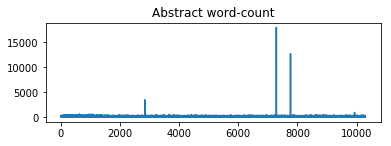

In [46]:
#plot = plt.figure(figsize=(80,80))
ax1 = plt.subplot(2,1,1)
ax1.plot(df_covid['abstract_word_count'])
#plt.xlim(right=2500)
ax1.set_title("Abstract word-count")

Text(0.5, 1.0, 'Article body-text word-count')

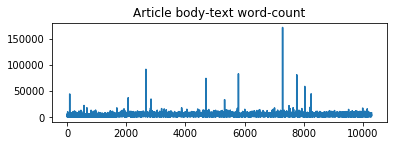

In [47]:
#plot = plt.figure(figsize=(100,108))
ax2 = plt.subplot(2,1,2)
ax2.plot(df_covid['body_word_count'])
ax2.set_title("Article body-text word-count")

count     10298.000000
mean       4299.501165
std        3347.096501
min          15.000000
25%        2686.000000
50%        3853.500000
75%        5423.000000
max      171326.000000
Name: body_word_count, dtype: float64

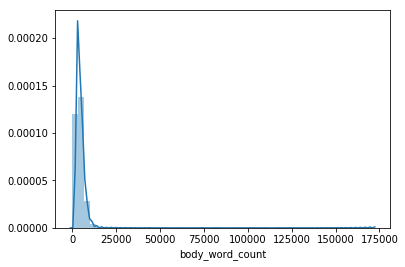

In [48]:
import seaborn as sns
sns.distplot(df_covid['body_word_count'])
df_covid['body_word_count'].describe()

count    10298.00000
mean      1350.30705
std        673.14116
min         15.00000
25%        971.25000
50%       1284.00000
75%       1654.00000
max      25516.00000
Name: body_unique_words, dtype: float64

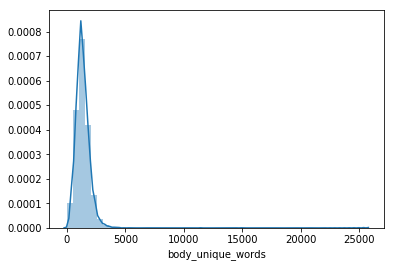

In [49]:
sns.distplot(df_covid['body_unique_words'])
df_covid['body_unique_words'].describe()

count    10298.000000
mean       220.646728
std        232.250953
min          1.000000
25%        168.000000
50%        215.000000
75%        269.000000
max      18000.000000
Name: abstract_word_count, dtype: float64

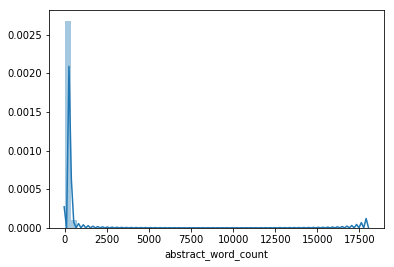

In [50]:
sns.distplot(df_covid['abstract_word_count'])
df_covid['abstract_word_count'].describe()

The above plots give us a good idea of the content we are dealing with. Most papers are about 5000 words in length. The long tails in both plots are caused by outliers. In fact, ~98% of the papers are under 20,000 words in length while a select few are over 200,000! <br><br>

In [51]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10298 entries, 0 to 10297
Data columns (total 8 columns):
paper_id               10298 non-null object
abstract               10043 non-null object
body_text              10298 non-null object
authors                10277 non-null object
title                  10298 non-null object
abstract_word_count    10298 non-null int64
body_word_count        10298 non-null int64
body_unique_words      10298 non-null int64
dtypes: int64(3), object(5)
memory usage: 643.7+ KB


In [52]:
df_covid['abstract'].describe(include='all')

count                                                 10043
unique                                                10042
top       The purpose of this table is to provide the co...
freq                                                      2
Name: abstract, dtype: object

The difference between the unique count and the total count means that either there are some duplicate abstracts or there are blank abstracts that are being counted as the same. 

In [53]:
df_covid['body_text'].describe(include='all')

count                                                 10298
unique                                                10296
top       Because the increased prescriptions of antidep...
freq                                                      2
Name: body_text, dtype: object

The difference between the unique count and the total count means that there are some duplicate articles present in the dataset. This coulde be possible if the authors had sent their papers to different journals.

In [54]:
df_covid.drop_duplicates(['abstract'],inplace=True)

df_covid['abstract'].describe(include='all')

count                                                 10042
unique                                                10042
top       BACKGROUND: Bronchoalveolar lavage (BAL) is ut...
freq                                                      1
Name: abstract, dtype: object

In [55]:
df_covid.drop_duplicates(['body_text'],inplace=True)

df_covid['body_text'].describe(include='all')

count                                                 10042
unique                                                10042
top       Knowledge of the protein composition of a viru...
freq                                                      1
Name: body_text, dtype: object

In [56]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10042 entries, 0 to 10297
Data columns (total 8 columns):
paper_id               10042 non-null object
abstract               10041 non-null object
body_text              10042 non-null object
authors                10032 non-null object
title                  10042 non-null object
abstract_word_count    10042 non-null int64
body_word_count        10042 non-null int64
body_unique_words      10042 non-null int64
dtypes: int64(3), object(5)
memory usage: 706.1+ KB


In [57]:
df_covid.describe()

,abstract_word_count,body_word_count,body_unique_words
count,10042.000000,10042.000000,10042.000000
mean,226.229038,4335.083549,1361.626369
std,232.509374,2989.377797,620.020085
min,1.000000,15.000000,15.000000
25%,173.000000,2755.500000,993.000000
50%,218.000000,3917.000000,1298.000000
75%,270.000000,5461.500000,1666.000000
max,18000.000000,171326.000000,25516.000000


# Data Preprocessing

We now clean the text data so that our key words are clear and we do not have to worry about details we are not concerned about. [ref1](https://towardsdatascience.com/nlp-text-preprocessing-a-practical-guide-and-template-d80874676e79)  [ref2](https://www.geeksforgeeks.org/text-preprocessing-in-python-set-1/)

Firstly By now looking at the abstract columns, we must notice that the text scraped from these articles is not perfect.

For example, many of the abstracts start with the word *Abstract* glued to the beginning of the first word of the real abstract body. 

## Cleaning dirty abstracts

In [58]:
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: str(x).replace('Abstract',''))
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: str(x).replace('abstract',''))
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: str(x).replace('ABSTRACT',''))
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: str(x).replace('ABSTRARCT',''))
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: str(x).replace('Background',''))
df_covid.head(10)

,paper_id,abstract,body_text,authors,title,abstract_word_count,body_word_count,body_unique_words
0,0015023cc06b5362d332b3baf348d11567ca2fbb,The positive stranded RNA genomes of picornavi...,"VP3, and VP0 (which is further processed to VP...",Joseph C. Ward. Lidia Lasecka-Dykes...,('The RNA pseudoknots in foot-and-mouth diseas...,194,1709,704
1,00340eea543336d54adda18236424de6a5e91c9d,"During the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...",Carla Mavian. Simone Marini...,('Regaining perspective on SARS-CoV-2 molecula...,138,2487,1032
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,We integrate the human movement and healthcare...,The 2019-nCoV epidemic has spread across China...,Hanchu Zhou. Jianan Yang...,('Healthcare-resource-adjusted vulnerabilities...,34,749,378
3,00911cf4f99a3d5ae5e5b787675646a743574496,The fast accumulation of viral metagenomic dat...,"Metagenomic sequencing, which allows us to dir...",Jiayu Shang. Yanni Sun,('CHEER: hierarCHical taxonomic classification...,139,5153,1371
4,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by...",Salman L. Butt. Eric C. Erwood...,"('Real-time, MinION-based, amplicon sequencing...",248,3958,1199
5,00eb9220dc8cd351393b6b035323d350f103f8c6,"Importance: As with other traumatic events, pa...","Evidence from prior pandemics suggests that, a...",Victor M. Castro. Roy H Perlis,('Impact of COVID-19 on psychiatric assessment...,246,2103,759
6,0139ea4ca580af99b602c6435368e7fdbefacb03,Nipah Virus (NiV) came into limelight recently...,Nipah is an infectious negative-sense single-s...,Nishi Kumari. Ayush Upadhyay...,('A Combined Evidence Approach to Prioritize N...,326,2382,1034
7,013d9d1cba8a54d5d3718c229b812d7cf91b6c89,: A novel coronavirus (2019-nCoV) emerged in W...,"In December 2019, a cluster of patients with p...",Shengjie Lai. Isaac Bogoch...,('Assessing spread risk of Wuhan novel coronav...,292,4596,1205
8,018fb5e62fbbcae07d57d94d29ac630dcc4dccf9,Introduction: Recent events highlight how emer...,Recent events highlight how emerging and re-em...,DAVIDE GORI. Erik Boetto...,('Analysis of the scientific literature in the...,200,2906,1131
9,01d162d7fae6aaba8e6e60e563ef4c2fca7b0e18,Faced with the current large-scale public heal...,The sudden outbreak of the new coronavirus (SA...,Xiaoyang Ji. Chunming Zhang...,"('TWIRLS, an automated topic-wise inference me...",223,4386,1309


Now let us remove all punctuation from text and change it to lowercase

In [59]:
start_time = datetime.now()
# import nltk 
import string 
import re 
end_time = datetime.now()
print(f'imported text preprocessing libraries, time taken:{end_time-start_time}')

imported text preprocessing libraries, time taken:0:00:00.000138


## Lower Case conversion

In [60]:
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: str(x).lower())
df_covid.head()

,paper_id,abstract,body_text,authors,title,abstract_word_count,body_word_count,body_unique_words
0,0015023cc06b5362d332b3baf348d11567ca2fbb,the positive stranded rna genomes of picornavi...,"VP3, and VP0 (which is further processed to VP...",Joseph C. Ward. Lidia Lasecka-Dykes...,('The RNA pseudoknots in foot-and-mouth diseas...,194,1709,704
1,00340eea543336d54adda18236424de6a5e91c9d,"during the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...",Carla Mavian. Simone Marini...,('Regaining perspective on SARS-CoV-2 molecula...,138,2487,1032
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,we integrate the human movement and healthcare...,The 2019-nCoV epidemic has spread across China...,Hanchu Zhou. Jianan Yang...,('Healthcare-resource-adjusted vulnerabilities...,34,749,378
3,00911cf4f99a3d5ae5e5b787675646a743574496,the fast accumulation of viral metagenomic dat...,"Metagenomic sequencing, which allows us to dir...",Jiayu Shang. Yanni Sun,('CHEER: hierarCHical taxonomic classification...,139,5153,1371
4,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,infectious bronchitis (ib) causes significant ...,"Infectious bronchitis (IB), which is caused by...",Salman L. Butt. Eric C. Erwood...,"('Real-time, MinION-based, amplicon sequencing...",248,3958,1199


In [61]:
df_covid['body_text'] = df_covid['body_text'].apply(lambda x: str(x).lower())
df_covid.head()

,paper_id,abstract,body_text,authors,title,abstract_word_count,body_word_count,body_unique_words
0,0015023cc06b5362d332b3baf348d11567ca2fbb,the positive stranded rna genomes of picornavi...,"vp3, and vp0 (which is further processed to vp...",Joseph C. Ward. Lidia Lasecka-Dykes...,('The RNA pseudoknots in foot-and-mouth diseas...,194,1709,704
1,00340eea543336d54adda18236424de6a5e91c9d,"during the past three months, a new coronaviru...","in december 2019, a novel coronavirus, sars-co...",Carla Mavian. Simone Marini...,('Regaining perspective on SARS-CoV-2 molecula...,138,2487,1032
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,we integrate the human movement and healthcare...,the 2019-ncov epidemic has spread across china...,Hanchu Zhou. Jianan Yang...,('Healthcare-resource-adjusted vulnerabilities...,34,749,378
3,00911cf4f99a3d5ae5e5b787675646a743574496,the fast accumulation of viral metagenomic dat...,"metagenomic sequencing, which allows us to dir...",Jiayu Shang. Yanni Sun,('CHEER: hierarCHical taxonomic classification...,139,5153,1371
4,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,infectious bronchitis (ib) causes significant ...,"infectious bronchitis (ib), which is caused by...",Salman L. Butt. Eric C. Erwood...,"('Real-time, MinION-based, amplicon sequencing...",248,3958,1199


## Removing Punctuation

In [62]:
print("Punctuated:\n",df_covid['abstract'][1],'\n\n\n')
translator = str.maketrans(' ',' ',string.punctuation)
print("Cleaned:\n",df_covid['abstract'][1].translate(translator))

Punctuated:
 during the past three months, a new coronavirus (sars-cov-2) epidemic has been growing exponentially, affecting over 100 thousand people worldwide, and causing enormous distress to economies and societies of affected countries. a plethora of analyses based on viral sequences has already been published, in scientific journals as well as through non-peer reviewed channels, to investigate sars-cov-2 genetic heterogeneity and spatiotemporal dissemination. we examined all full genome sequences currently available to assess the presence of sufficient information for reliable phylogenetic and phylogeographic studies. our analysis clearly shows severe limitations in the present data, in light of which any finding should be considered, at the very best, preliminary and hypothesis-generating. hence the need for avoiding stigmatization based on partial information, and for continuing concerted efforts to increase number and quality of the sequences required for robust tracing of the 

In [63]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [74]:
start_time= datetime.now()
tqdm.pandas()
df_covid['abstract'] = df_covid['abstract'].progress_apply(lambda x: str(x).translate(translator))
df_covid.head()
end_time=datetime.now()
print(f'removed all punctuation from all abstracts. time taken:{end_time-start_time}')

100%|██████████| 10040/10040 [00:00<00:00, 10752.79it/s]

removed all punctuation from all abstracts. time taken:0:00:01.298440


In [75]:
start_time= datetime.now()
tqdm.pandas()
df_covid['body_text'] = df_covid['body_text'].progress_apply(lambda x: str(x).translate(translator))
df_covid.head()
end_time=datetime.now()
print(f'removed all punctuation from all body_texts. time taken:{end_time-start_time}')

100%|██████████| 10040/10040 [00:28<00:00, 355.79it/s]

removed all punctuation from all body_texts. time taken:0:00:28.225383


## Handling multiple languages
Reference [link](https://www.kaggle.com/maksimeren/covid-19-literature-clustering)

Going over the dataset, we see that there are papers in other languages. This may make processing very expensive if we were to tranlate to english for processing along with the other articles. It is als possible that the concepts may not carry over very well into the translation. Hence we discard those papers.

In [66]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df_covid))):
    # split by space into list, take the first x intex, join with space
    text = df_covid.iloc[ii]['abstract'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # in case beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            lang = "unknown"
            pass
    
    # get the language    
    languages.append(lang)

100%|██████████| 10042/10042 [01:36<00:00, 103.59it/s]


In [67]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 10042

{'en': 10040, 'it': 1, 'tl': 1}


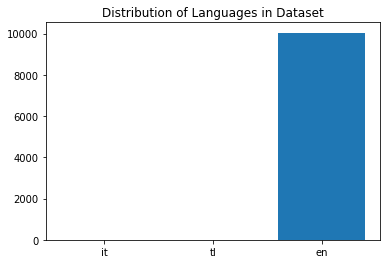

In [68]:
df_covid['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()

In [69]:
df_covid = df_covid[df_covid['language'] == 'en'] 
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10040 entries, 0 to 10297
Data columns (total 9 columns):
paper_id               10040 non-null object
abstract               10040 non-null object
body_text              10040 non-null object
authors                10030 non-null object
title                  10040 non-null object
abstract_word_count    10040 non-null int64
body_word_count        10040 non-null int64
body_unique_words      10040 non-null int64
language               10040 non-null object
dtypes: int64(3), object(6)
memory usage: 784.4+ KB


## Dropping unrelated columns

In [70]:
abstracts = df_covid.drop(["paper_id","body_text", "abstract_word_count", "body_word_count","body_unique_words", "authors", "title","language"], axis=1)
abstracts.head()

,abstract,language
0,the positive stranded rna genomes of picornavi...,en
1,during the past three months a new coronavirus...,en
2,we integrate the human movement and healthcare...,en
3,the fast accumulation of viral metagenomic dat...,en
4,infectious bronchitis ib causes significant ec...,en


In [71]:
bodytexts = df_covid.drop(["paper_id","abstract", "abstract_word_count", "body_word_count","body_unique_words", "authors", "title","language"], axis=1)
bodytexts.head()

,body_text,language
0,vp3 and vp0 which is further processed to vp2 ...,en
1,in december 2019 a novel coronavirus sarscov2 ...,en
2,the 2019ncov epidemic has spread across china ...,en
3,metagenomic sequencing which allows us to dire...,en
4,infectious bronchitis ib which is caused by in...,en


## Tokenization and removal of stop words

Here we use the spacy tokenizer and stop words parser. It is designed around biological and clinical articles, and hence is more efficient than the general nltk english stopwords dataset.

In [261]:
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step

In [262]:
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['which',
 'off',
 'several',
 'due',
 '’ll',
 'various',
 'down',
 'themselves',
 'there',
 'first']

Now the above stopwords are used in everyday english text. Research papers will often frequently use words that don't actually contribute to the meaning and are not considered everyday stopwords.

Thank you Daniel Wolffram for the idea.
#### Cite: [Custom Stop Words | Topic Modeling: Finding Related Articles](https://www.kaggle.com/danielwolffram/topic-modeling-finding-related-articles)

In [263]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www','the','and','in','of'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

### Next lets create a function that will process the text data for us. 
For this purpose we will be using the spacy library. This function will convert text to lower case, remove punctuation, and find and remove stopwords. For the parser, we will use en_core_sci_lg. This is a model for processing biomedical, scientific or clinical text.

In [264]:
# Parser
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [265]:
tqdm.pandas()
abstracts["processed_text"] = df_covid["abstract"].progress_apply(spacy_tokenizer)

100%|██████████| 10040/10040 [05:08<00:00, 32.56it/s]


Talk about our first less cool attempt which used a very simple pronoun removing nltk stopword corpora

In [81]:
# import nltk
# #nltk.download('stopwords') ##Stopword corpora
# #nltk.download('punkt')  ##Tokenizer
# from nltk.tokenize import word_tokenize 
# from nltk.corpus import stopwords

# #stopwords = nltk.corpus.stopwords.words('english')

# def normalize_document(doc):

#     # lower case and remove special characters\whitespaces

#     doc = str(doc).strip()
#     doc = str(doc).lower()
    
#     translator = str.maketrans(' ',' ',string.punctuation)  #where string.punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
#     doc = str(doc).translate(translator)

#     # tokenize document

#     stop_words = set(stopwords.words('english')) 
#     word_tokens = word_tokenize(doc) 
#     filtered_text = [word for word in word_tokens if word not in stop_words] 
#     filtered_text =  " ".join([i for i in filtered_text])
#     return filtered_text

In [82]:
# stop_words = set(stopwords.words('english')) 
# stop_words

In [83]:
# start_time= datetime.now()
# abstract_tokens = abstracts['abstract'].apply(lambda x: normalize_document(x))
# end_time= datetime.now()
# print(f'Tokenized and removed stopwords from {len(abstracts)} abstracts. Time Taken:{end_time - start_time}')

In [84]:
# abstract_tokens.head()

### Tokenizing and removing stopwords from body texts

In [85]:
# start_time= datetime.now()
# body_tokens = bodytexts['body_text'].apply(lambda x: normalize_document(x))
# end_time= datetime.now()
# print(f'Tokenized and removed stopwords from {len(bodytexts)} body texts. Time Taken:{end_time - start_time}')

In [86]:
# body_tokens.head()

# Word Cloud of Abstracts

In this section we visualize the more important terms in the text file by creating a word cloud of the abstracts we have got. [ref](https://www.datacamp.com/community/tutorials/wordcloud-python)

In [87]:
import wordcloud as wc

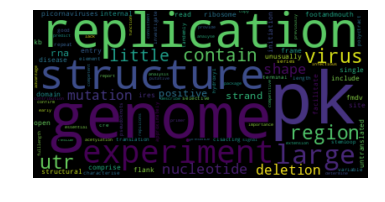

In [89]:
# Start with one review:

text = abstracts['processed_text'][0]

# Create and generate a word cloud image:
wordcloud = wc.WordCloud(colormap='hls').generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
print(f"Total number of abstracts: {len(abstracts['abstract'])}")
print(f"Number of nan abstracts: {abstracts['abstract'].value_counts()['nan']}")

In [ ]:
abstracts = abstracts.loc[~(abstracts['abstract'] == 'nan')]

In [ ]:
print(f"Dropped nan abstracts. Total number of abstracts: {len(abstracts['processed_text'])}")

In [ ]:
start_time = datetime.now()
wordcloud2 = wc.WordCloud(width=1920,height=1080,colormap='cool').generate(' '.join(abstracts['processed_text'])) #joining all the abstracts into one huge text block and passing it as input to the wordcloud generator
end_time=datetime.now()
print(f'generated wordclouds from all {len(abstracts)} abstracts. time taken:{end_time-start_time}')

In [ ]:
plot = plt.figure(figsize=(60, 60))
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

# Forming Word Vectors for Dimensionality Reduction

In this section, we form word vectors of our abstracts and body texts in order to be able to modify the resulting vectors to find similar meaning words.
We are using the *Term Frequency- Inverse Document Frequency* calculation to form word vectors. It gives us an idea as to which terms are more frequent/common in the text and which are rarer and seemingly more representative terms in the body text/abstract.

Doing this also reduces our feature list to something more reasonable, given that if we look over the entire dataset, there will be upto [13 million](#Statistics) unique features.

In [ ]:
abstract_tokens.describe()

Though we have cleaned the abstracts and body texts and also tokenized them, the TDIDFVectorizer present in SciKit Learn does not need tokenized input, rather the whole collection of abstract texts. We provide the earlier cleaned and processed *abstract* and *bodytexts* DataTables for this purpose

In [ ]:
abstracts[0:20]

In [ ]:
bodytexts[0:20]

# Checkpoint!!

In [ ]:
abstracts.to_csv("./abstracts.csv", index=False)
bodytexts.to_csv("./bodytexts.csv", index=False)

# Restore Point

In [ ]:
abstracts = pd.read_csv("./abstracts.csv",index_col=False)
bodytexts = pd.read_csv("./bodytexts.csv",index_col=False)

In [ ]:
abstracts.head()

In [ ]:
bodytexts.head()

## Spark Paralleizable implementation

[Spark Documentation Reference](https://spark.apache.org/docs/2.2.0/mllib-feature-extraction.html)

[Spark implementation reference](https://medium.com/@rezandry/find-most-relevance-text-data-using-pyspark-with-tf-idf-a4269a13e59)

Big Deal ? Spark.ml vs Spark.mllib [link](https://stackoverflow.com/questions/38835829/whats-the-difference-between-spark-ml-and-mllib-packages)

TODO: Plot the TF-IDF values some way

In [ ]:
spark.stop()

## Creating Spark Session

In [92]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

In [93]:
# Create Spark session
spark = SparkSession.builder \
                    .appName("SparkTFIDF2-ElectricBogaloo") \
                    .config("spark.driver.memory", "15g") \
                    .config("spark.kryoserializer.buffer.max","2047") \
                    .getOrCreate()

conf = spark.conf#SparkConf().setAppName("SparkTFIDF")
spark.conf.set("spark.kryoserializer.buffer.max", "2047")
#sc = SparkContext(conf=conf)


In [94]:
print(len(abstracts))
abstracts[0:10]

10040


,abstract,language,processed_text
0,the positive stranded rna genomes of picornavi...,en,positive strand rna genome picornaviruses comp...
1,during the past three months a new coronavirus...,en,past month new coronavirus sarscov2 epidemic g...
2,we integrate the human movement and healthcare...,en,integrate human movement healthcare resource d...
3,the fast accumulation of viral metagenomic dat...,en,fast accumulation viral metagenomic datum cont...
4,infectious bronchitis ib causes significant ec...,en,infectious bronchitis ib cause significant eco...
5,importance as with other traumatic events pand...,en,importance traumatic event pandemic coronaviru...
6,nipah virus niv came into limelight recently d...,en,nipah virus niv come limelight recently outbre...
7,a novel coronavirus 2019ncov emerged in wuhan...,en,novel coronavirus 2019ncov emerge wuhan city c...
8,introduction recent events highlight how emerg...,en,introduction recent event highlight emerge ree...
9,faced with the current largescale public healt...,en,face current largescale public health emergenc...


to work with pyspark and spark APIs, it would be better if we transformed our pandas dataframes to datastructures that it is more comfortable with, such as the SQLcontext Dataframe. This will hopefully make desigining the rest of the tf-idf parallelizable pipeline easier.

# Vectorizing with TF-IDF

In [156]:
from pyspark.mllib.feature import HashingTF, IDF

start_time = datetime.now()
print(start_time)
# Load documents (one per line).
documents = spark.sparkContext.parallelize(abstracts['processed_text'][:2000]).map(lambda line: line.split(" "))

hashingTF = HashingTF(numFeatures = 2 ** 12)
tf = hashingTF.transform(documents)

# While applying HashingTF only needs a single pass to the data, applying IDF needs two passes:
# First to compute the IDF vector and second to scale the term frequencies by IDF.
tf.cache()
idf = IDF().fit(tf)
tfidf = idf.transform(tf)

# spark.mllib's IDF implementation provides an option for ignoring terms
# which occur in less than a minimum number of documents.
# In such cases, the IDF for these terms is set to 0.
# This feature can be used by passing the minDocFreq value to the IDF constructor.
idfIgnore = IDF(minDocFreq=2).fit(tf)
tfidfIgnore = idfIgnore.transform(tf)
end_time = datetime.now()
print(f'Calculated the TF-IDF TDM for the set of {len(abstracts)} abstracts. time taken:{end_time - start_time}')

2020-05-03 12:02:12.393240
Calculated the TF-IDF TDM for the set of 10040 abstracts. time taken:0:00:00.964608


## Reference Code

In [249]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X
text = abstracts['processed_text'][:2000].values
X = vectorize(text, 2 ** 12)
X.shape

(2000, 4096)

# PCA

We will apply Principle Component Analysis (PCA) to our vectorized data. The reason for this is that by keeping a large number of dimensions with PCA, you don’t destroy much of the information, but hopefully will remove some noise/outliers from the data, and make the clustering problem easier for k-means. Note that X_reduced will only be used for k-means, t-SNE will still use the original feature vector X that was generated through tf-idf on the NLP processed text.


In [103]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix

In [104]:
start_time = datetime.now()
print(start_time)
rows = spark.sparkContext.parallelize(tfidfIgnore.collect())

mat = RowMatrix(rows)

# Compute the top (2048) principal components.
# Principal components are stored in a local dense matrix.
pc = mat.computePrincipalComponents(3000)

# Project the rows to the linear space spanned by the top (2048) principal components.
X_reduced = mat.multiply(pc)
end_time = datetime.now()
print(f'{type(X_reduced)} \n. 2048 Principal components analysed. time taken: {end_time - start_time} ')

2020-05-03 11:02:41.061197
<class 'pyspark.mllib.linalg.distributed.RowMatrix'> 
. 2048 Principal components analysed. time taken: 0:04:46.575760 


In [105]:
X_reduced.numRows(), X_reduced.numCols()

(2000, 3000)

To separate the literature, k-means will be run on the vectorized text. Given the number of clusters, k, k-means will categorize each vector by taking the mean distance to a randomly initialized centroid. The centroids are updated iteratively.

## Reference Code

100%|██████████| 18/18 [02:57<00:00,  9.84s/it]


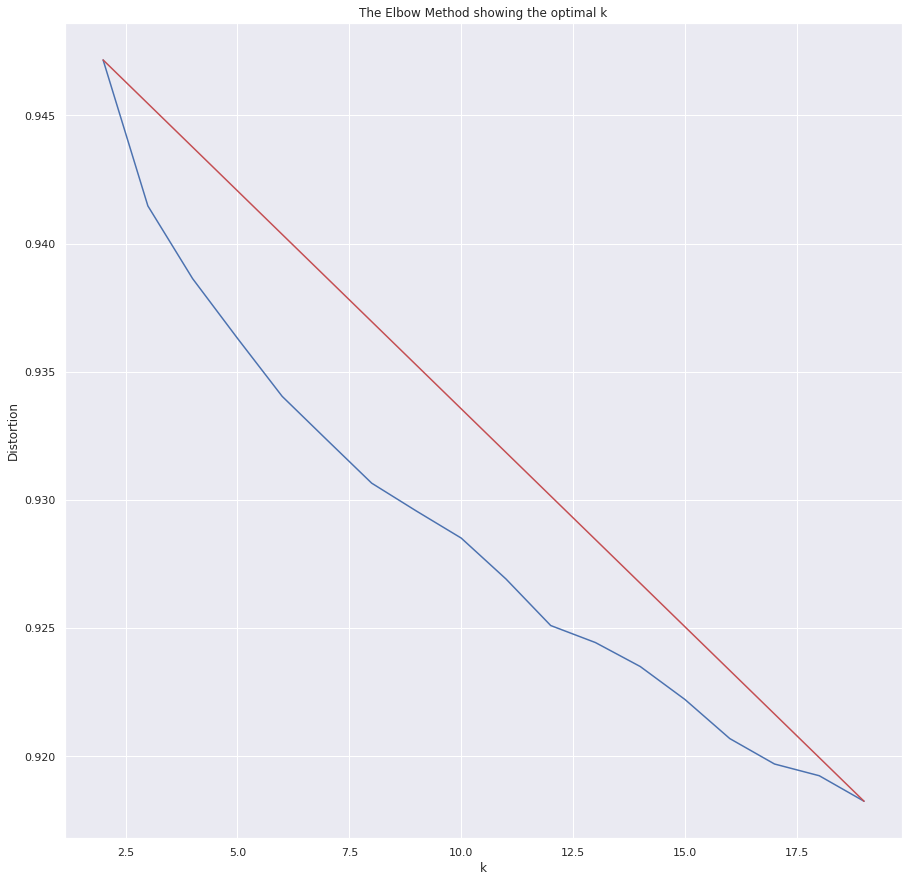

In [250]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

from sklearn.cluster import KMeans

from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 20)
for k in tqdm(K):
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Elbow method to determine the optimal number of clusters for k-means clustering

In [99]:
from pyspark.mllib.clustering import KMeans
import numpy as np
from tqdm import tqdm

cost = np.zeros(20)
for k in tqdm(range(2, 20)):
    model = KMeans.train(X_reduced.rows,
                         k,
                         maxIterations=10,
                         initializationMode="random",
                         seed=50,
                         initializationSteps=5,
                         epsilon=1e-4)

    cost[k] = model.computeCost(X_reduced.rows)

100%|██████████| 18/18 [00:41<00:00,  2.33s/it]


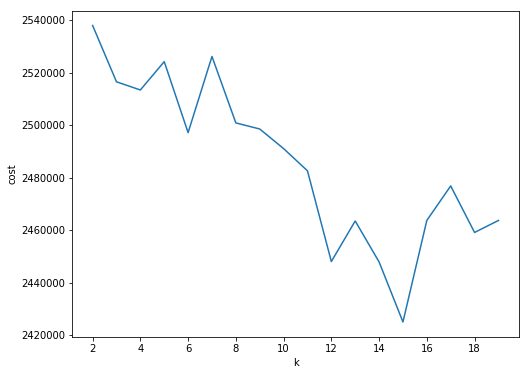

In [100]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sbs
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20), cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

## K-means clustering

From the eblow method used above, we have determined the optimum range of number of clusters to use. We now perform the clustering using the aapropriate k value. 

In [ ]:
from pyspark.mllib.clustering import KMeans, KMeansModel

cluster_centers = []

# Build the model (cluster the data)
for k in tqdm(range(14, 21)):
    clusters = KMeans.train(X_reduced.rows,
                            k,
                            maxIterations=10,
                            initializationMode="random",
                            seed=50,
                            initializationSteps=5,
                            epsilon=1e-4)
    
    # Evaluate clustering by computing Within Set Sum of Squared Errors
    def error(point):
        center = clusters.centers[clusters.predict(point)]
        return np.sqrt(sum([x**2 for x in (point - center)]))

    WSSSE = projected.rows.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    print("The cluster {} has Within Set Sum of Squared Error {}".format(k, WSSSE))
    
    centers = clusters.clusterCenters
    
    cluster_centers.append(centers)

# Dimensionality Reduction with t-SNE

Using [t-SNE](https://lvdmaaten.github.io/tsne) we can reduce our high dimensional features vector to 2 dimensions. By using the 2 dimensions as x,y coordinates, the body_text can be plotted. 

> t-Distributed Stochastic Neighbor Embedding (t-SNE) reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space
> #### Cite: [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow: Second Edition | Aurélien Geron](https://github.com/ageron/handson-ml2)

In [163]:
from sklearn.manifold import TSNE
import joblib
start_time = datetime.now()
print(f'Start time: {start_time}')
tsne = TSNE(verbose=1, perplexity=100, random_state=42,n_iter=250,learning_rate=200)
X_embedded = tsne.fit_transform(tfidfIgnore.collect())
end_time = datetime.now()
print(f'T-SNE model fit on the TF-IDF document term matrix of {k} clusters. Time taken:{end_time-start_time}')

Start time: 2020-05-03 12:13:15.944820
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2000 samples in 1.214s...
[t-SNE] Computed neighbors for 2000 samples in 38.776s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 10.460854
[t-SNE] KL divergence after 250 iterations with early exaggeration: 130.411011
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.000000
T-SNE model fit on the TF-IDF document term matrix of 15 clusters. Time taken:0:07:13.749030


In [172]:
type(X_embedded)

numpy.ndarray

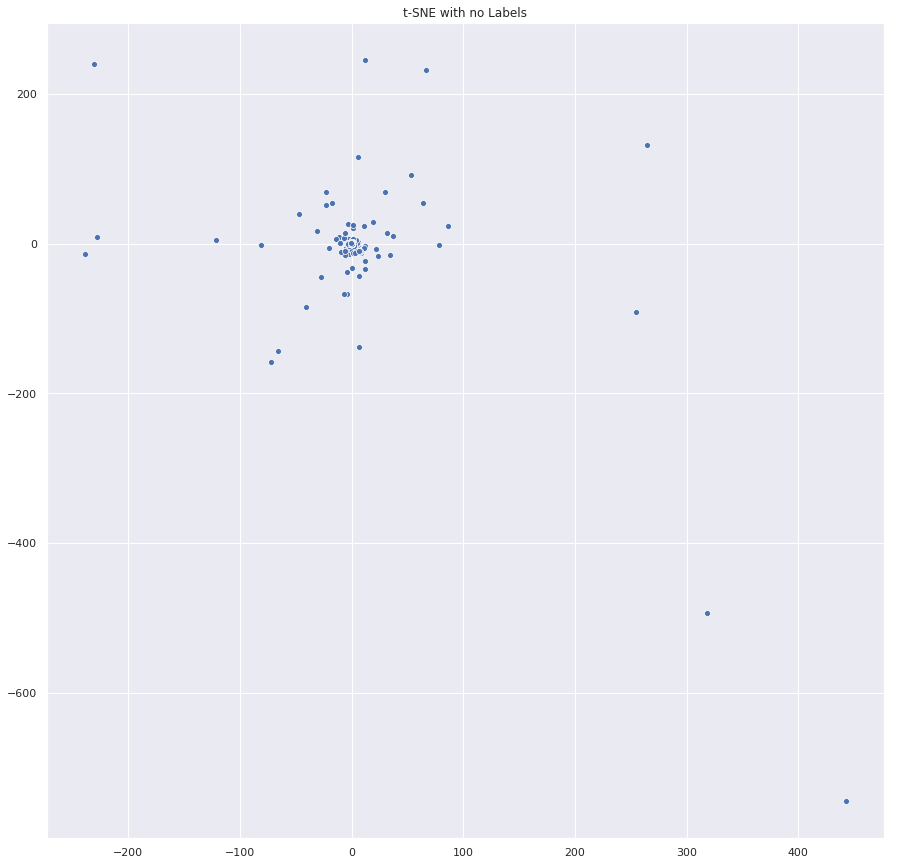

In [173]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()

In the above k-means running experiment, we can see from plotting the error that the least error occurs at 16 clusters. Hence below we run kmeans one more time using k=16 to get the predicted centres of the clusters.

In [174]:
start_time = datetime.now()
print(f'Start time: {start_time}')
k = 15
model = KMeans.train(X_reduced.rows,
                     k,
                     maxIterations=10,
                     initializationMode="random",
                     seed=50,
                     initializationSteps=5,
                     epsilon=1e-4)

y_pred = model.predict(X_reduced.rows)
end_time = datetime.now()
print(f'K-means|| run on {k} clusters. Time taken:{end_time-start_time}')

Start time: 2020-05-03 12:22:38.579845
K-means|| run on 15 clusters. Time taken:0:00:02.817917


In [175]:
y_pred.sample(1,0.1)

PythonRDD[919] at RDD at PythonRDD.scala:53

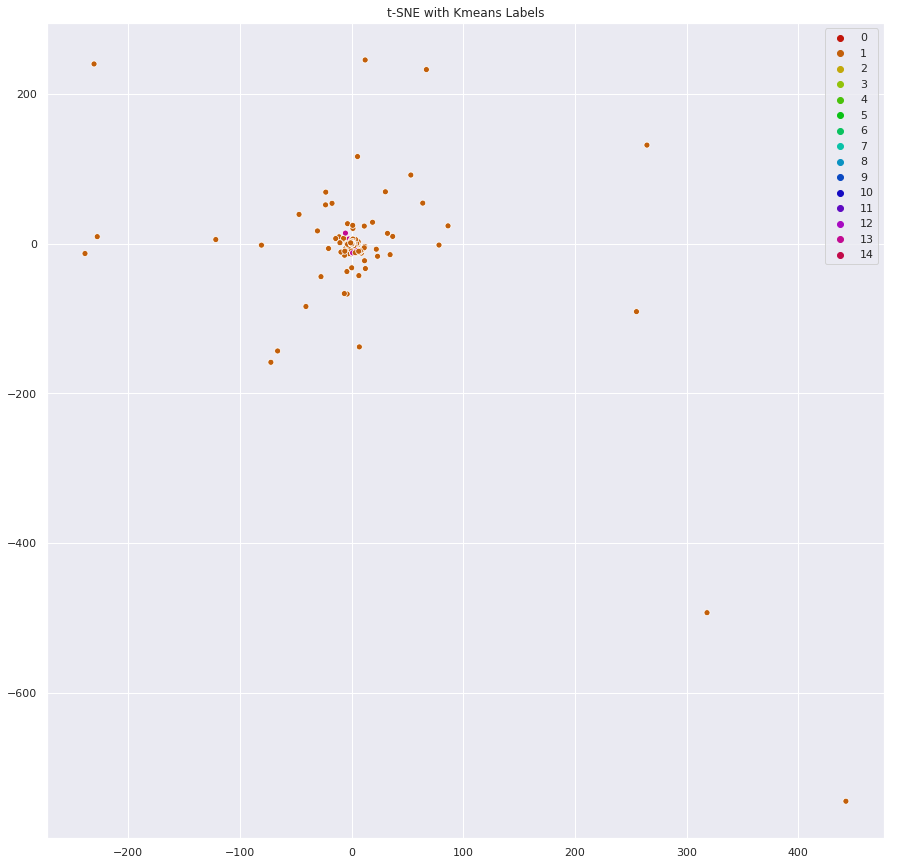

In [176]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(k, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred.collect(), legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

In [ ]:
# sc.stop()

## Reference code

In [135]:
#transform the dataframe to a format that can be used as input for LDA.train. LDA train expects a RDD with lists,
#where the list consists of a uid and (sparse) Vector
def parseVectors(line):
    return [int(line[2]), line[0]]
sparsevector = result_index.select('id','processed_text','features')#.map(parseVectors)

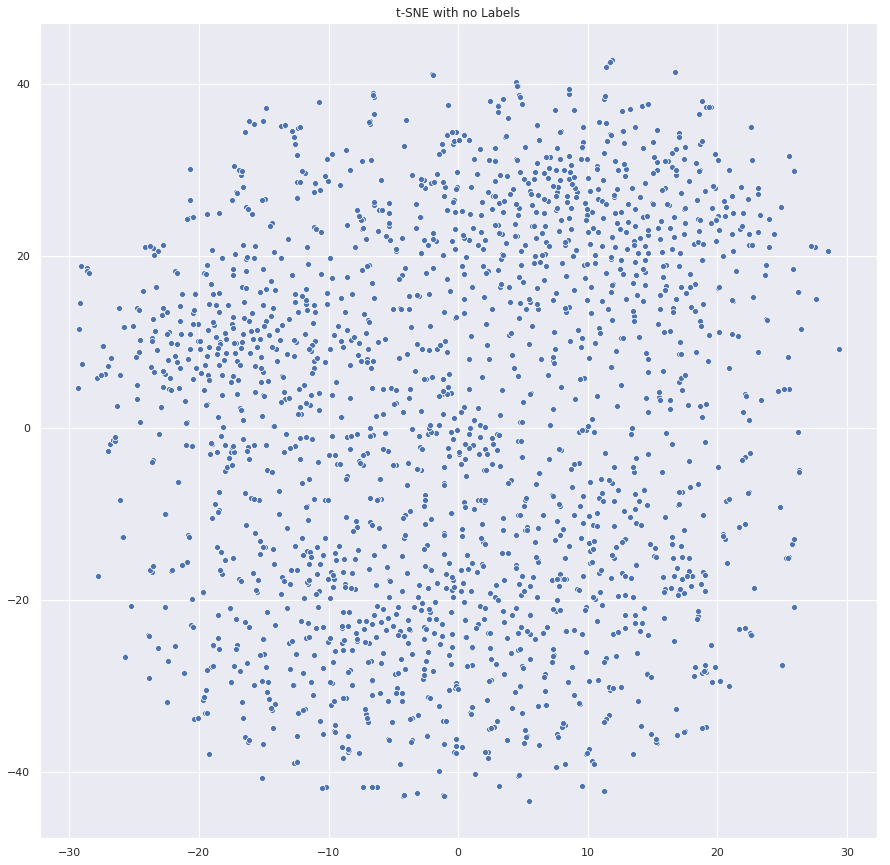

In [252]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()

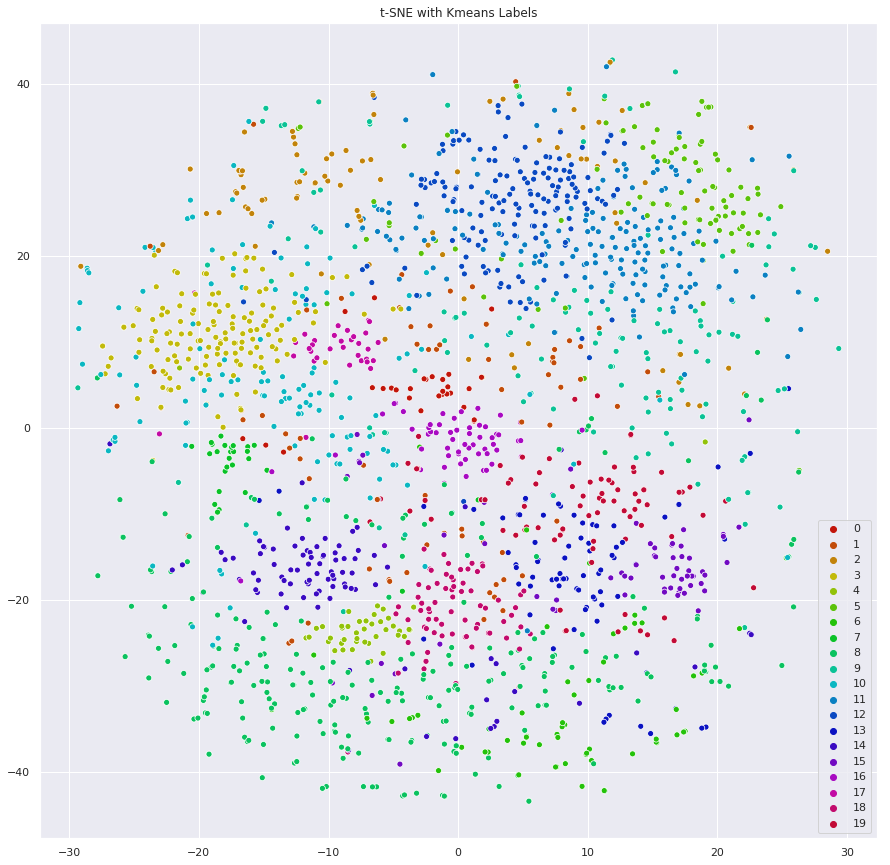

In [253]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

# LDA
Reference: [Gist by Bergvca illustrating LDA](https://gist.github.com/Bergvca/a59b127afe46c1c1c479)

In [268]:
from pyspark import sql
df_LDA = abstracts.drop(["language"],axis=1)
spdf = sql.SQLContext(spark.sparkContext).createDataFrame(df_LDA)

print(spdf.__repr__())

spdf.head(20)

DataFrame[abstract: string, processed_text: string]


[Row(abstract='the positive stranded rna genomes of picornaviruses comprise a single large open reading frame flanked by 5′ and 3′ untranslated regions utrs footandmouth disease virus fmdv has an unusually large 5′ utr 13 kb containing five structural domains these include the internal ribosome entry site ires which facilitates initiation of translation and the cisacting replication element cre less well characterised structures are a 5′ terminal 360 nucleotide stemloop a variable length polyctract of approximately 100200 nucleotides and a series of two to four tandemly repeated pseudoknots pks we investigated the structures of the pks by selective 2′ hydroxyl acetylation analysed by primer extension shape analysis and determined their contribution to genome replication by mutation and deletion experiments shape and mutation experiments confirmed the importance of the previously predicted pk structures for their function deletion experiments showed that although pks are not essential f

again here, the HashingTF(term frequency hashing class) requires a string input, so we will again use the *abstracts* and the *bodytexts* datatables.

Below you can see the use of an optimized Pipeline class implemented in Spark, a streamlined API for chaining up algorithm stages. It provides optimizations that otherwise would take me a lot of reading in the apache spark docs and googling to do. 
Pipeline reference:[link](https://spark.apache.org/docs/latest/ml-pipeline.html#example-pipeline)

In [229]:
from pyspark.ml.feature import HashingTF, Tokenizer
tokenizer = Tokenizer(inputCol="abstract", outputCol="words")
tokens = tokenizer.transform(spdf)

In [230]:
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol="words", outputCol="features")
cvmodel = cv.fit(tokens)
result = cvmodel.transform(tokens)
result.show()
type(result)

+--------------------+--------------------+--------------------+--------------------+
|            abstract|      processed_text|               words|            features|
+--------------------+--------------------+--------------------+--------------------+
|the positive stra...|positive strand r...|[the, positive, s...|(79547,[0,1,2,3,4...|
|during the past t...|past month new co...|[during, the, pas...|(79547,[0,1,2,3,4...|
|we integrate the ...|integrate human m...|[we, integrate, t...|(79547,[0,2,3,4,6...|
|the fast accumula...|fast accumulation...|[the, fast, accum...|(79547,[0,1,2,3,4...|
|infectious bronch...|infectious bronch...|[infectious, bron...|(79547,[0,1,2,3,4...|
|importance as wit...|importance trauma...|[importance, as, ...|(79547,[0,1,2,3,4...|
|nipah virus niv c...|nipah virus niv c...|[nipah, virus, ni...|(79547,[0,1,2,3,4...|
| a novel coronavi...|novel coronavirus...|[, a, novel, coro...|(79547,[0,1,2,3,4...|
|introduction rece...|introduction rece...|[introducti

pyspark.sql.dataframe.DataFrame

In [232]:
from pyspark.sql.functions import monotonically_increasing_id 

result_index = result.select("*").withColumn("id", monotonically_increasing_id())
result_index.show()

+--------------------+--------------------+--------------------+--------------------+---+
|            abstract|      processed_text|               words|            features| id|
+--------------------+--------------------+--------------------+--------------------+---+
|the positive stra...|positive strand r...|[the, positive, s...|(79547,[0,1,2,3,4...|  0|
|during the past t...|past month new co...|[during, the, pas...|(79547,[0,1,2,3,4...|  1|
|we integrate the ...|integrate human m...|[we, integrate, t...|(79547,[0,2,3,4,6...|  2|
|the fast accumula...|fast accumulation...|[the, fast, accum...|(79547,[0,1,2,3,4...|  3|
|infectious bronch...|infectious bronch...|[infectious, bron...|(79547,[0,1,2,3,4...|  4|
|importance as wit...|importance trauma...|[importance, as, ...|(79547,[0,1,2,3,4...|  5|
|nipah virus niv c...|nipah virus niv c...|[nipah, virus, ni...|(79547,[0,1,2,3,4...|  6|
| a novel coronavi...|novel coronavirus...|[, a, novel, coro...|(79547,[0,1,2,3,4...|  7|
|introduct

In [233]:
#transform the dataframe to a format that can be used as input for LDA.train. LDA train expects a RDD with lists,
#where the list consists of a uid and (sparse) Vector
def parseVectors(line):
    return [int(line[2]), line[0]]
sparsevector = result_index.select('id','processed_text','features')

In [234]:
sparsevector.show()

+---+--------------------+--------------------+
| id|      processed_text|            features|
+---+--------------------+--------------------+
|  0|positive strand r...|(79547,[0,1,2,3,4...|
|  1|past month new co...|(79547,[0,1,2,3,4...|
|  2|integrate human m...|(79547,[0,2,3,4,6...|
|  3|fast accumulation...|(79547,[0,1,2,3,4...|
|  4|infectious bronch...|(79547,[0,1,2,3,4...|
|  5|importance trauma...|(79547,[0,1,2,3,4...|
|  6|nipah virus niv c...|(79547,[0,1,2,3,4...|
|  7|novel coronavirus...|(79547,[0,1,2,3,4...|
|  8|introduction rece...|(79547,[0,1,2,3,4...|
|  9|face current larg...|(79547,[0,1,2,3,4...|
| 10|virus interact th...|(79547,[0,1,2,3,4...|
| 11|school closure co...|(79547,[0,1,2,3,4...|
| 12|posttranscription...|(79547,[0,1,2,3,4...|
| 13|outbreak emerge i...|(79547,[0,1,2,3,4...|
| 14|recent outbreak c...|(79547,[0,1,2,3,4...|
| 15|quantitative reve...|(79547,[0,1,2,3,4...|
| 16|spread covid19 en...|(79547,[0,1,2,3,4...|
| 17|human astroviruse...|(79547,[0,1,2,

In [235]:
from pyspark.ml.clustering import LDA
#Train the LDA model
lda = LDA(k=10, maxIter=20,checkpointInterval=10)
start_time = datetime.now()
ldamodel = lda.fit(sparsevector)
end_time = datetime.now()
print(lda,ldamodel,f'LDA model fit on all of the abstracts. Time taken:{end_time-start_time}')

LDA_41b71013cac6 LDA_41b71013cac6 LDA model fit on all of the abstracts. Time taken:0:00:59.397132


In [237]:
print(f'The lower bound on the log likelihood of the entire corpus is {model.logLikelihood(sparsevector)}.')
print(f'And the upper bound on perplexity is {model.logPerplexity(sparsevector)}')

# Describe topics.
topics = model.describeTopics(3)
print("The topics described by their top-weighted terms:")
topics.show(truncate=False)

# Shows the result
transformed = model.transform(sparsevector)

transformed.show()

The lower bound on the log likelihood of the entire corpus is -17817428.66256673.
And the upper bound on perplexity is 7.842951357249451
The topics described by their top-weighted terms:
+-----+---------------+---------------------------------------------------------------------+
|topic|termIndices    |termWeights                                                          |
+-----+---------------+---------------------------------------------------------------------+
|0    |[0, 1, 2]      |[0.046741163486125545, 0.039953432344546576, 0.035608092439616934]   |
|1    |[2, 0, 3]      |[7.346543845262518E-4, 3.8974086248224715E-4, 2.409995332669076E-4]  |
|2    |[0, 2, 1]      |[0.006592605582402051, 0.005093210281198349, 0.004228448993247746]   |
|3    |[600, 191, 245]|[4.7080711723162654E-5, 4.442023967739245E-5, 4.214581636534285E-5]  |
|4    |[3, 2, 1]      |[2.3826625506019925E-4, 2.0661105860946336E-4, 1.617602414793374E-4] |
|5    |[0, 2, 1]      |[4.6897908242423666E-4, 4.228523736381

In [246]:
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import udf

def indices_to_terms(vocabulary):
    def indices_to_terms(xs):
        return [vocabulary[int(x)] for x in xs]
    return udf(indices_to_terms, ArrayType(StringType()))

In [248]:
topics.withColumn("topics_words", indices_to_terms(cvmodel.vocabulary)("termIndices")).show()

+-----+---------------+--------------------+---------------+
|topic|    termIndices|         termWeights|   topics_words|
+-----+---------------+--------------------+---------------+
|    0|      [0, 1, 2]|[0.04674116348612...| [the, of, and]|
|    1|      [2, 0, 3]|[7.34654384526251...| [and, the, in]|
|    2|      [0, 2, 1]|[0.00659260558240...| [the, and, of]|
|    3|[600, 191, 245]|[4.70807117231626...|   [vs, 95, ci]|
|    4|      [3, 2, 1]|[2.38266255060199...|  [in, and, of]|
|    5|      [0, 2, 1]|[4.68979082424236...| [the, and, of]|
|    6|  [614, 992, 2]|[0.00123181602390...|[kim, lee, and]|
|    7|      [0, 1, 2]|[0.03813955750373...| [the, of, and]|
|    8|      [1, 0, 3]|[0.00314503373774...|  [of, the, in]|
|    9|      [0, 1, 2]|[0.00405899583106...| [the, of, and]|
+-----+---------------+--------------------+---------------+



In [226]:
cvmodel.vocabulary

['the',
 'of',
 'and',
 'in',
 'to',
 'a',
 'with',
 'for',
 'that',
 'is',
 'were',
 'was',
 'we',
 'by',
 'as',
 'from',
 'this',
 'virus',
 'on',
 'are',
 'infection',
 'an',
 'be',
 'viral',
 'or',
 'patients',
 'cells',
 'study',
 'these',
 'have',
 'results',
 '',
 'which',
 'disease',
 'at',
 'viruses',
 'respiratory',
 'has',
 'human',
 'not',
 'data',
 'using',
 'protein',
 'health',
 'influenza',
 'been',
 'between',
 'can',
 'also',
 'our',
 'cell',
 'cases',
 'may',
 'other',
 'their',
 'during',
 'used',
 'clinical',
 'analysis',
 'but',
 'infections',
 'covid19',
 'more',
 'than',
 'it',
 'most',
 'methods',
 'rna',
 'expression',
 'two',
 'proteins',
 'all',
 'however',
 'host',
 'both',
 'its',
 'model',
 'different',
 'associated',
 'response',
 'against',
 'immune',
 'high',
 'identified',
 'studies',
 'potential',
 'such',
 'background',
 'found',
 'control',
 'including',
 'samples',
 'one',
 'into',
 'infectious',
 'severe',
 'coronavirus',
 'gene',
 'transmission'

In [ ]:
# from pyspark.ml import Pipeline
# from pyspark.ml.feature import HashingTF
# from pyspark.ml.feature import IDF
# from pyspark.ml.feature import Tokenizer

# # Configure an ML pipeline, which consists of three stages: tokenizer, hashingTF, and lr.
# tokenizer = Tokenizer(inputCol="abstract", outputCol="words")
# hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="rawFeatures")
# idf = IDF(inputCol="rawFeatures", outputCol="features",minDocFreq=2)
# pipeline = Pipeline(stages=[tokenizer, hashingTF, idf])

# start_time = datetime.now()
# pipelinemodel = pipeline.fit(spdf)
# training_transform = pipelinemodel.transform(spdf)
# end_time = datetime.now()
# print(type(pipelinemodel),type(training_transform),f'\nTFIDF computed. Time taken: {end_time-start_time}')

# training_transform.toPandas()['rawFeatures'][0]

# print(training_transform['rawFeatures'])

# training_transform, training_transform.count()

# from pyspark.ml.clustering import LDA

# spdf.head(2)

# start_time = datetime.now()
# # Trains a LDA model.
# lda = LDA(k=10, maxIter=20,checkpointInterval=10)
# model = lda.fit(training_transform)
# end_time = datetime.now()
# print(lda,model,f'LDA model fit on all of the abstracts. Time taken:{end_time-start_time}')

# print(f'The lower bound on the log likelihood of the entire corpus is {model.logLikelihood(training_transform)}.')
# print(f'And the upper bound on perplexity is {model.logPerplexity(training_transform)}')

# # Describe topics.
# topics = model.describeTopics(3)
# print("The topics described by their top-weighted terms:")
# topics.show(truncate=False)

# # Shows the result
# transformed = model.transform(training_transform)
# transformed.show(truncate=False)

# topn_words = 10
# num_topics = 10

# topics = model.topicsMatrix().toArray()
# for topic in range(num_topics):
#     print("Topic " + str(topic) + ":")
#     for word in range(0, topn_words): 
#         print(" " + str(topics[word][topic]))

## Reference Code

In [254]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [255]:
vectorizers = []
    
for ii in range(0, 20):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

vectorizers[0]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=None, min_df=5,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}',
                tokenizer=None, vocabulary=None)

In [256]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(abstracts1000.loc[abstracts1000['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

len(vectorized_data)

20

In [257]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 20

lda_models = []
for ii in range(0, 20):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=False)

In [258]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

In [259]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [267]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

print(all_keywords[0][:10])

print(len(all_keywords))

['patient', 'positive', 'rate', 'method', 'sample', 'population', 'pool', 'screen', 'symptom', 'group']
20


Though this is not humanly interpretable, these are the vector embeddings of words that describe each topic. These can be found in the output of the HashingTF that we use. but since we're using a pipeline for efficiency, we cannot cross reference this output with the output of the hashing TF used to transform the data in the pipeline above.

Hence we implement this using scikit learn to make it simpler to understand and run.

### Save current outputs to file

Re-running some parts of the notebook (especially vectorization and t-SNE) are time intensive tasks. We want to make sure that the important outputs for generating the bokeh plot are saved for future use.

In [ ]:
f=open('topics.txt','w')

count = 0

for ii in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1

f.close()

In [ ]:
import pickle

# save the COVID-19 DataFrame, too large for github
pickle.dump(df, open("df_covid.p", "wb" ))

# save the final t-SNE
pickle.dump(X_embedded, open("X_embedded.p", "wb" ))

# save the labels generate with k-means(20)
pickle.dump(y_pred, open("y_pred.p", "wb" ))

# Classification and cross validation using Multi-Layer Perceptrons

### F Score, Precision, Recall, and Accuracy

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
type(tfidfIgnore),type(y_pred)

In [ ]:
# Load training data
data = spark.read.format("libsvm")\
    .load("data/mllib/sample_multiclass_classification_data.txt")

# Split the data into train and test
splits = data.randomSplit([0.6, 0.4], 1234)
train = splits[0]
test = splits[1]

# specify layers for the neural network:
# input layer of size 4 (features), two intermediate of size 5 and 4
# and output of size 3 (classes)
layers = [4, 5, 4, 3]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)

# train the model
model = trainer.fit(train)

# compute accuracy on the test set
result = model.transform(test)
predictionAndLabels = result.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

In [ ]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")
    

In [ ]:
from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(X.toarray(),y_pred, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier


In [ ]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(400, 100), max_iter=200, random_state=1)


In [ ]:
start_time = datetime.now()
clf.fit(X_train, y_train)
end_time = datetime.now()
print(f'training time taken:{end_time-start_time}')


In [ ]:
start_time = datetime.now()
pred = cross_val_predict(clf, X_train, y_train, n_jobs=-1)
end_time = datetime.now()
print(f'cross validation time taken:{end_time-start_time}')
classification_report("MLP Report (Training Set)", y_train, sgd_pred)


In [ ]:
start_time = datetime.now()
pred = cross_val_predict(clf, X_test, y_test, cv=3, n_jobs=-1)
end_time = datetime.now()
print(f'test time taken:{end_time-start_time}')


In [ ]:
classification_report("MLP Report (Test Set)", y_test, sgd_pred)


In [ ]:
cv_score = cross_val_score(clf, X.toarray(), y_pred, cv=10)


In [ ]:
print("Mean cv Score - MLP: {:,.3f}".format(float(cv_score.mean()) * 100), "%")


## Bonus: Find top N closest words for given input query

In [ ]:
#Generate doc
localDoc = abstracts['abstract']
doc = sc.parallelize(localDoc).map(lambda line: line.split(" "))

In [ ]:
from pyspark.mllib.feature import Word2Vec
start_time = datetime.now()
# Learn a mapping from words to Vectors.
model = Word2Vec().fit(doc)
end_time = datetime.now()
print(f'Word2Vec model fit on the {len(abstracts)} abstracts. Time Taken: {end_time - start_time}')

In [ ]:
word = "corona"
topN = 10
synonyms = model.findSynonyms(word, topN)
result = [(s[0], s[1]) for s in synonyms]

# Visualization and stuff

https://cdn.oreillystatic.com/en/assets/1/event/261/Text%20analytics%20and%20new%20visualization%20techniques%20Presentation.pdf

# Plotting the data
The previous steps have given us clustering labels and a dataset of papers reduced to two dimensions. By pairing this with Bokeh, we can create an interactive plot of the literature. This should organize the papers such that related publications are in close proximity. To try to undertstand what the similarities may be, we have also performed topic modelling on each cluster of papers in order to pick out the key terms.

Bokeh will pair the actual papers with their positions on the t-SNE plot. Through this approach it will be easier to see how papers fit together, allowing for both exploration of the dataset and evaluation of the clustering. 

In [178]:
# required libraries for plot
                                
import bokeh
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, Slider, TapTool, TextInput
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap, transform
from bokeh.io import output_file, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import RadioButtonGroup, TextInput, Div, Paragraph
from bokeh.layouts import column, widgetbox, row, layout
from bokeh.layouts import column

from call_back import input_callback, selected_code  # file with customJS callbacks for bokeh
       # github.com/MaksimEkin/COVID19-Literature-Clustering/blob/master/lib/call_backs.py

In [ ]:
import os

topic_path = 'topics.txt'
with open(topic_path) as f:
    topics = f.readlines()

# References

1. [COVID-19 Open Research Dataset Challenge (CORD-19)](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/)
2. [How to build a topic-based search engine](https://www.smithinst.co.uk/insights/build-topic-based-search-engine/)
3. W. Buntine et al., "A Scalable Topic-Based Open Source Search Engine," IEEE/WIC/ACM International Conference on Web Intelligence (WI'04), Beijing, China, 2004, pp. 228-234.
4. [Semantic Topic Modeling for Search Queries at Google](https://gofishdigital.com/semantic-topic-modeling/)
5. GRANT, C.; PAZHAYIDAM GEORGE, C.; KANJILAL, V.; NIRKHIWALE, S.; WILSON, J.; WANG, D.. A Topic-Based Search, Visualization, and Exploration System. Florida Artificial Intelligence Research Society Conference, North America, apr. 2015. Available at: <https://www.aaai.org/ocs/index.php/FLAIRS/FLAIRS15/paper/view/10445/10360>. Date accessed: 25 Apr. 2020.